In [ ]:
#creating a python representation of the LSM algorithm

In [19]:
#American Put option Price with Laguerre degree up to k=9
import numpy as np

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)]  # L0(x) = 1

    if k >= 1:
        A.append(1 - X)  # L1(x) = 1 - x
    if k >= 2:
        A.append(0.5 * (2 - 4*X + X**2))  # L2(x)
    if k >= 3:
        A.append((1/6) * (6 - 18*X + 9*X**2 - X**3))  # L3(x)
    if k >= 4:
        A.append((1/24) * (24 - 96*X + 72*X**2 - 16*X**3 + X**4))  # L4(x)
    if k >= 5:
        A.append((1/120) * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5))  # L5(x)
    if k >= 6:
        A.append((1/720) * (720 - 4320*X + 5400*X**2 - 2400*X**3 + 450*X**4 - 36*X**5 + X**6))  # L6(x)
    if k >= 7:
        A.append((1/5040) * (5040 - 35280*X + 52920*X**2 - 29400*X**3 + 7350*X**4 - 882*X**5 + 49*X**6 - X**7))  # L7(x)
    if k >= 8:
        A.append((1/40320) * (40320 - 322560*X + 564480*X**2 - 376320*X**3 + 117600*X**4 - 17640*X**5 + 1372*X**6 - 56*X**7 + X**8))  # L8(x)
    if k >= 9:
        A.append((1/362880) * (362880 - 3265920*X + 6531840*X**2 - 5227200*X**3 + 1995840*X**4 - 408240*X**5 + 45360*X**6 - 2520*X**7 + 63*X**8 - X**9))  # L9(x)

    if k > 9:
        raise ValueError("Maximum degree supported is 9. Please increase if needed.")
    A = np.column_stack(A)
    return A


def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1)  # Time vector
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)

    P = np.maximum(K - S, 0)

    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
    
        itmP = np.where(K - S > 0)[0]
        X = S[itmP]
        Y = P[itmP] * np.exp(-r * dt)
    
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        

        E = K - X
        exP = itmP[C < E]
        rest = np.setdiff1d(np.arange(M), exP)
        

        P[exP] = E[C < E]
        P[rest] = P[rest] * np.exp(-r * dt)
    

    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value


T = 1         
r = 0.03    
sigma = 0.15   
K = 100       
S0 = 90     
N = 50      
M = 1000000     
k = 9      

option_value = LSM(T, r, sigma, K, S0, N, M, k)

print(f"Estimated option value: {option_value:.4f}")

Estimated option value: 10.6835


In [ ]:
#Pricing American call with Laguerre Polynomials 

import numpy as np

def basis_funct(X, k):
    # Convert X to a NumPy array for element-wise operations
    X = np.asarray(X)
    
    # Create basis function matrix depending on the degree k
    if k == 1:
        A = np.column_stack([np.ones_like(X), 1 - X])
    elif k == 2:
        A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2)])
    elif k == 3:
        A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2), 
                             1/6 * (6 - 18 * X + 9 * X**2 - X**3)])
    elif k == 4:
        A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2), 
                             1/6 * (6 - 18 * X + 9 * X**2 - X**3),
                             1/24 * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4)])
    elif k == 5:
        A = np.column_stack([np.ones_like(X), 1 - X, 1/2 * (2 - 4 * X + X**2), 
                             1/6 * (6 - 18 * X + 9 * X**2 - X**3),
                             1/24 * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4),
                             1/120 * (120 - 600 * X + 600 * X**2 - 200 * X**3 + 25 * X**4 - X**5)])
    else:
        raise ValueError("Too many basis functions requested")
    
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1)  # Time vector
    

    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    
    # **Change 1**: Payoff at maturity (call option)
    P = np.maximum(S - K, 0)
    

    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        
        # **Change 2**: In-the-money paths for a call option
        itmP = np.where(S > K)[0]
        X = S[itmP]
        Y = P[itmP] * np.exp(-r * dt)
        
    
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        
        # **Change 3**: Immediate exercise value for a call option
        E = X - K
        exP = itmP[C < E]
        rest = np.setdiff1d(np.arange(M), exP)
        
        # **Change 4**: Update payoffs based on call option logic
        P[exP] = E[C < E]
        P[rest] = P[rest] * np.exp(-r * dt)
    
   
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value

# Parameters
T = 1.0  # Maturity
r = 0.05  # Interest rate
sigma = 0.2  # Volatility
K = 100  # Strike price
S0 = 95  # Initial stock price
N = 244  # Time steps
M = 100000  # Simulations
k = 5  # Basis function degree


call_option_value = LSM(T, r, sigma, K, S0, N, M, k)
print(f"American Call Option Value: {call_option_value}")


American Call Option Value: 7.450641825955014


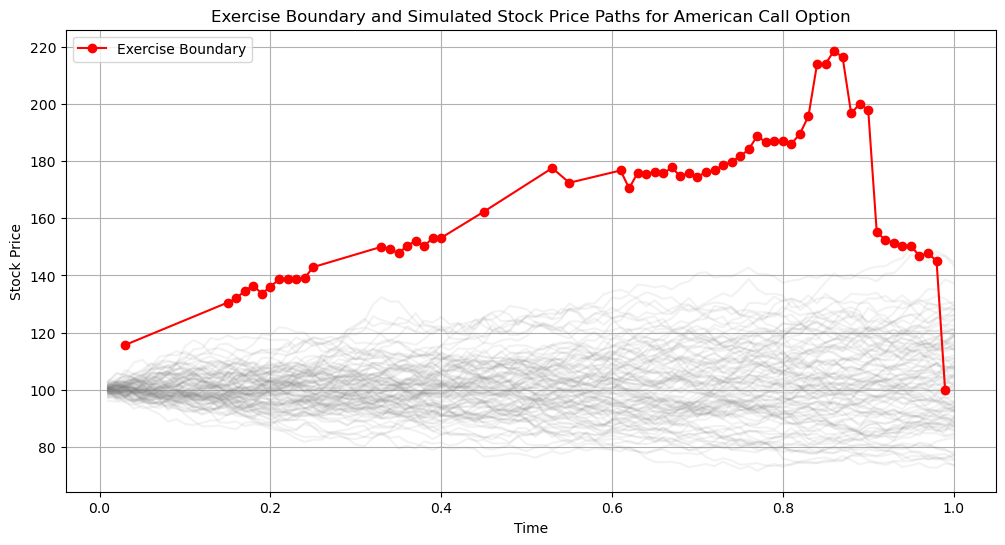

Option Value: 8.648096847881307


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    
    if k == 1:
        A = np.column_stack([np.ones_like(X), 1 - X])
    elif k == 2:
        A = np.column_stack([
            np.ones_like(X),
            1 - X,
            0.5 * (2 - 4 * X + X**2)
        ])
    elif k == 3:
        A = np.column_stack([
            np.ones_like(X),
            1 - X,
            0.5 * (2 - 4 * X + X**2),
            (1/6) * (6 - 18 * X + 9 * X**2 - X**3)
        ])
    elif k == 4:
        A = np.column_stack([
            np.ones_like(X),
            1 - X,
            0.5 * (2 - 4 * X + X**2),
            (1/6) * (6 - 18 * X + 9 * X**2 - X**3),
            (1/24) * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4)
        ])
    elif k == 5:
        A = np.column_stack([
            np.ones_like(X),
            1 - X,
            0.5 * (2 - 4 * X + X**2),
            (1/6) * (6 - 18 * X + 9 * X**2 - X**3),
            (1/24) * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4),
            (1/120) * (120 - 600 * X + 600 * X**2 - 200 * X**3 + 25 * X**4 - X**5)
        ])
    else:
        raise ValueError("Too many basis functions requested")
    
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2, N)
    Z = np.concatenate([z, -z], axis=0)
    W = np.cumsum(np.sqrt(dt) * Z, axis=1)  
    S = S0 * np.exp((r - 0.5 * sigma**2) * t[1:] + sigma * W) 
    P = np.maximum(S[:, -1] - K, 0)
    exercise_boundaries = []

    for i in range(N - 1, 0, -1):
        itmP = np.where(S[:, i] - K > 0)[0]
        X = S[itmP, i] / K  
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = S[itmP, i] - K
        exP_local = np.where(C < E)[0]
        P[itmP[exP_local]] = E[exP_local]
        P[itmP] = P[itmP] * np.exp(-r * dt)
        
        if len(exP_local) > 0:
            exercise_boundaries.append((t[i], np.min(S[itmP[exP_local], i])))
    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, exercise_boundaries, S, t

T = 1.0 
r = 0.05 
sigma = 0.15 
K = 100 
S0 = 100 
N = 100  
M = 1000000  
k = 5  

option_value, exercise_boundaries, S, t = LSM(T, r, sigma, K, S0, N, M, k)
times, boundaries = zip(*reversed(exercise_boundaries)) 
plt.figure(figsize=(12, 6))
num_paths_to_plot = 100
sample_paths = S[:num_paths_to_plot, :]
for i in range(num_paths_to_plot):
    plt.plot(t[1:], sample_paths[i, :], color='grey', alpha=0.1)


plt.plot(times, boundaries, marker='o', color='red', label='Exercise Boundary')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary and Simulated Stock Price Paths for American Call Option')
plt.legend()
plt.grid(True)
plt.show()

print(f"Option Value: {option_value}")


American Put Option Value: 4.2522


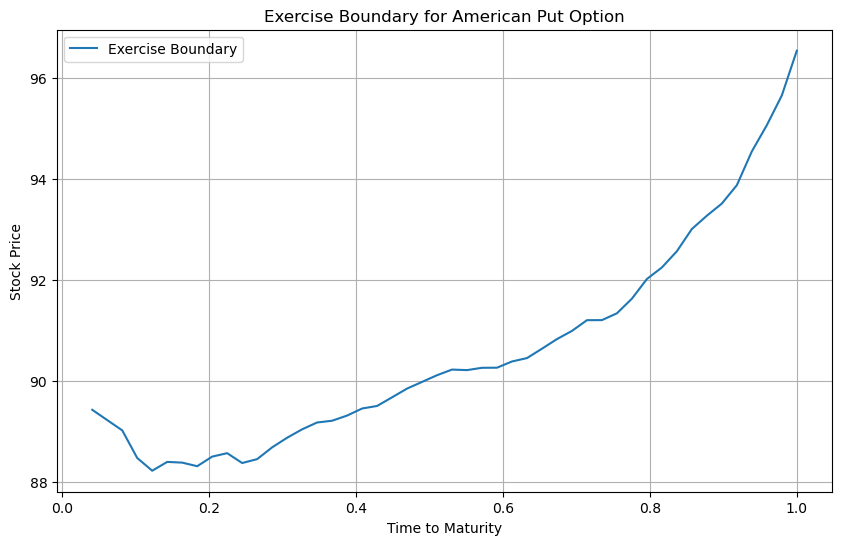

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    
    if k == 1:
        A = np.column_stack([np.ones_like(X), X])
    elif k == 2:
        A = np.column_stack([np.ones_like(X), X, X**2])
    elif k == 3:
        A = np.column_stack([np.ones_like(X), X, X**2, X**3])
    elif k == 4:
        A = np.column_stack([np.ones_like(X), X, X**2, X**3, X**4])
    elif k == 5:
        A = np.column_stack([np.ones_like(X), X, X**2, X**3, X**4, X**5])
    else:
        raise ValueError("Too many basis functions requested")
    
    return A

def LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    np.random.seed(42) 
    z = np.random.randn(M, N)
    W = np.cumsum(np.sqrt(dt) * z, axis=1)
    W = np.hstack((np.zeros((M, 1)), W))
    S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    P = np.maximum(K - S[:, -1], 0)
    
    critical_prices = []

    for i in range(N - 1, 0, -1):
        itm = S[:, i] < K
        X = S[itm, i]
        Y = P[itm] * np.exp(-r * dt)
        A = basis_funct(X / K, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - X
        exercise = E > C
        P[itm] = np.where(exercise, E, P[itm] * np.exp(-r * dt))
        X_grid = np.linspace(0.5 * K, K, 1000)  
        A_grid = basis_funct(X_grid / K, k)
        C_grid = A_grid @ beta
        E_grid = K - X_grid

        diff = E_grid - C_grid
        idx = np.where(diff >= 0)[0]
        if len(idx) == 0:
            critical_price = np.nan
        else:
            idx = idx[-1]
            if idx == len(X_grid) - 1:
                critical_price = X_grid[-1]
            else:
                x1, x2 = X_grid[idx], X_grid[idx + 1]
                y1, y2 = diff[idx], diff[idx + 1]
                critical_price = x1 + y1 * (x2 - x1) / (y1 - y2)
        critical_prices.append(critical_price)
    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, critical_prices

T = 1.0   
r = 0.05  
sigma = 0.15 
K = 100    
S0 = 100   
N = 50   
M = 1000000 
k = 5      

put_option_value, critical_prices = LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k)
print(f"American Put Option Value: {put_option_value:.4f}")

critical_prices = critical_prices[::-1] 
time_steps = np.linspace(0, T, N)[1:]  
critical_prices = np.array(critical_prices)

valid_indices = ~np.isnan(critical_prices)
time_steps_valid = time_steps[valid_indices]
critical_prices_valid = critical_prices[valid_indices]
plt.figure(figsize=(10, 6))
plt.plot(time_steps_valid, critical_prices_valid, label='Exercise Boundary')


plt.xlabel('Time to Maturity')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary for American Put Option')
plt.legend()
plt.grid(True)
plt.show()


American Put Option Value: 4.2655


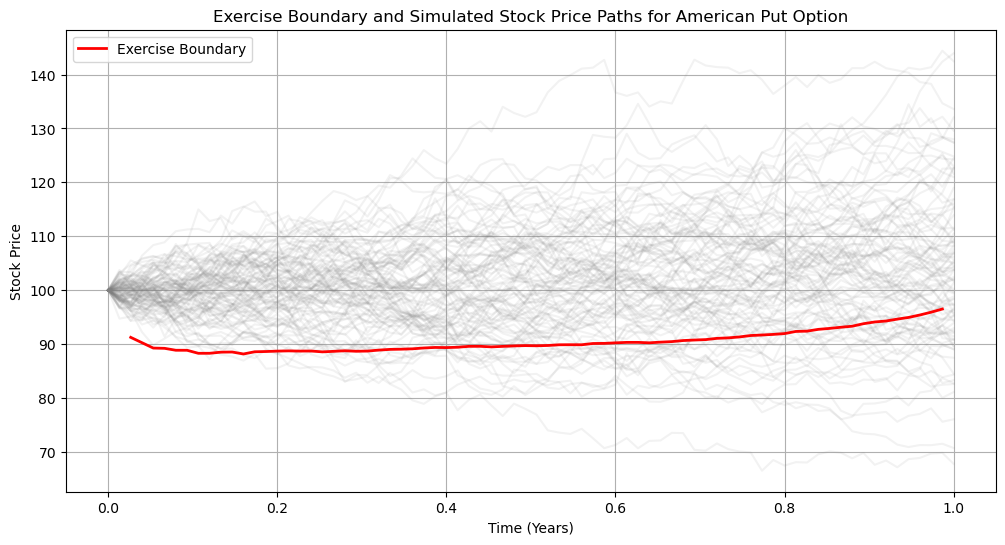

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):

    X = np.asarray(X)
    if k == 1:
        A = np.column_stack([np.ones_like(X), X])
    elif k == 2:
        A = np.column_stack([np.ones_like(X), X, X**2])
    elif k == 3:
        A = np.column_stack([np.ones_like(X), X, X**2, X**3])
    elif k == 4:
        A = np.column_stack([np.ones_like(X), X, X**2, X**3, X**4])
    elif k == 5:
        A = np.column_stack([np.ones_like(X), X, X**2, X**3, X**4, X**5])
    else:
        raise ValueError("Too many basis functions requested")
    return A

def LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 

    np.random.seed(42) 
    z = np.random.randn(M, N)
    W = np.cumsum(np.sqrt(dt) * z, axis=1)
    W = np.hstack((np.zeros((M, 1)), W))
    S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    P = np.maximum(K - S[:, -1], 0)
    critical_prices = []

    for i in range(N - 1, 0, -1):
        itm = S[:, i] < K
        X = S[itm, i]
        Y = P[itm] * np.exp(-r * dt)
        A = basis_funct(X / K, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - X
        exercise = E > C
        P[itm] = np.where(exercise, E, P[itm] * np.exp(-r * dt))
        X_grid = np.linspace(0.5 * K, K, 1000)  # From 0.5K to K
        A_grid = basis_funct(X_grid / K, k)
        C_grid = A_grid @ beta
        E_grid = K - X_grid
        diff = E_grid - C_grid
        idx = np.where(diff >= 0)[0]
        if len(idx) == 0:
            critical_price = np.nan
        else:
            idx = idx[-1]
            if idx == len(X_grid) - 1:
                critical_price = X_grid[-1]
            else:
             
                x1, x2 = X_grid[idx], X_grid[idx + 1]
                y1, y2 = diff[idx], diff[idx + 1]
                critical_price = x1 + y1 * (x2 - x1) / (y1 - y2)
        critical_prices.append(critical_price)


    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, critical_prices, S, t


T = 1.0   
r = 0.05  
sigma = 0.15
K = 100    
S0 = 100  
N = 75   
M = 1000000 
k = 5   

put_option_value, critical_prices, S, t = LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k)
print(f"American Put Option Value: {put_option_value:.4f}")

critical_prices = critical_prices[::-1] 
t_plot = t[1:-1] 
critical_prices = np.array(critical_prices)
valid_indices = ~np.isnan(critical_prices)
t_valid = t_plot[valid_indices]
critical_prices_valid = critical_prices[valid_indices]
plt.figure(figsize=(12, 6))
num_paths_to_plot = 100
sample_paths = S[:num_paths_to_plot, :]
for i in range(num_paths_to_plot):
    plt.plot(t, sample_paths[i, :], color='grey', alpha=0.1)

plt.plot(t_valid, critical_prices_valid, label='Exercise Boundary', color='red', linewidth=2)

plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary and Simulated Stock Price Paths for American Put Option')
plt.legend()
plt.grid(True)
plt.show()


American Put Option Value: 4.2656


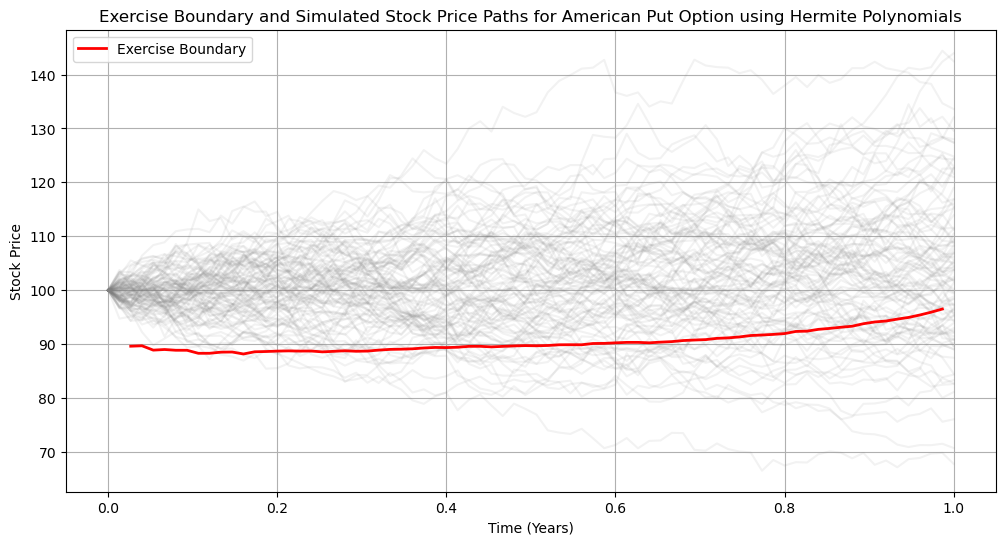

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)] 
    if k >= 1:
        A.append(X) 
    if k >= 2:
        A.append(X**2 - 1) 
    if k >= 3:
        A.append(X**3 - 3*X) 
    if k >= 4:
        A.append(X**4 - 6*X**2 + 3)  
    if k >= 5:
        A.append(X**5 - 10*X**3 + 15*X) 
    if k > 5:
        raise ValueError("Too many basis functions requested (max k=5)")
    A = np.column_stack(A)
    return A

def LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1)  
    np.random.seed(42) 
    z = np.random.randn(M, N)
    W = np.cumsum(np.sqrt(dt) * z, axis=1)
    W = np.hstack((np.zeros((M, 1)), W))
    S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    P = np.maximum(K - S[:, -1], 0)
    critical_prices = []

    for i in range(N - 1, 0, -1):
        itm = S[:, i] < K
        X = S[itm, i] / K  
        Y = P[itm] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - S[itm, i]
        exercise = E > C
        P[itm] = np.where(exercise, E, P[itm] * np.exp(-r * dt))
        X_grid = np.linspace(0.5, 1.0, 1000) 
        A_grid = basis_funct(X_grid, k)
        C_grid = A_grid @ beta
        E_grid = K - X_grid * K
        diff = E_grid - C_grid
        idx = np.where(diff >= 0)[0]
        if len(idx) == 0:
            critical_price = np.nan
        else:
            idx = idx[-1]
            if idx == len(X_grid) - 1:
                critical_price = X_grid[-1] * K
            else:
                x1, x2 = X_grid[idx], X_grid[idx + 1]
                y1, y2 = diff[idx], diff[idx + 1]
                critical_x = x1 + y1 * (x2 - x1) / (y1 - y2)
                critical_price = critical_x * K
        critical_prices.append(critical_price)
    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, critical_prices, S, t

T = 1.0   
r = 0.05   
sigma = 0.15 
K = 100   
S0 = 100   
N = 75    
M = 1000000  
k = 5    

put_option_value, critical_prices, S, t = LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k)
print(f"American Put Option Value: {put_option_value:.4f}")
critical_prices = critical_prices[::-1]  
t_plot = t[1:-1] 
critical_prices = np.array(critical_prices)

valid_indices = ~np.isnan(critical_prices)
t_valid = t_plot[valid_indices]
critical_prices_valid = critical_prices[valid_indices]

num_paths_to_plot = 100
sample_paths = S[:num_paths_to_plot, :]
for i in range(num_paths_to_plot):
    plt.plot(t, sample_paths[i, :], color='grey', alpha=0.1)
plt.plot(t_valid, critical_prices_valid, label='Exercise Boundary', color='red', linewidth=2)

plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary and Simulated Stock Price Paths for American Put Option using Hermite Polynomials')
plt.legend()
plt.grid(True)
plt.show()


American Put Option Value: 4.2656


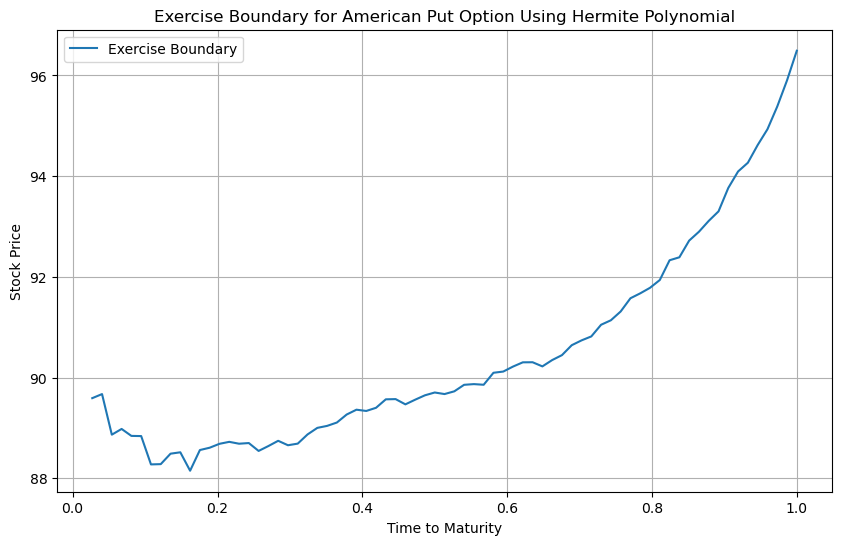

In [13]:
#Smoother Graph for the Hermite polynomial basis function
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)]  # H0(x) = 1
    if k >= 1:
        A.append(X) 
    if k >= 2:
        A.append(X**2 - 1) 
    if k >= 3:
        A.append(X**3 - 3*X) 
    if k >= 4:
        A.append(X**4 - 6*X**2 + 3)  
    if k >= 5:
        A.append(X**5 - 10*X**3 + 15*X) 
    if k > 5:
        raise ValueError("Too many basis functions requested (max k=5)")
    
    A = np.column_stack(A)
    return A
def LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1)  
    np.random.seed(42)  
    z = np.random.randn(M, N)
    W = np.cumsum(np.sqrt(dt) * z, axis=1)
    W = np.hstack((np.zeros((M, 1)), W))
    S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    P = np.maximum(K - S[:, -1], 0)

    critical_prices = []
    for i in range(N - 1, 0, -1):
        itm = S[:, i] < K
        X = S[itm, i]
        Y = P[itm] * np.exp(-r * dt)
        A = basis_funct(X / K, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - X
        exercise = E > C
        P[itm] = np.where(exercise, E, P[itm] * np.exp(-r * dt))
        X_grid = np.linspace(0.5 * K, K, 1000) 
        A_grid = basis_funct(X_grid / K, k)
        C_grid = A_grid @ beta
        E_grid = K - X_grid
        diff = E_grid - C_grid
        idx = np.where(diff >= 0)[0]
        if len(idx) == 0:
            critical_price = np.nan
        else:
            idx = idx[-1]
            if idx == len(X_grid) - 1:
                critical_price = X_grid[-1]
            else:
                x1, x2 = X_grid[idx], X_grid[idx + 1]
                y1, y2 = diff[idx], diff[idx + 1]
                critical_price = x1 + y1 * (x2 - x1) / (y1 - y2)
        critical_prices.append(critical_price)
    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, critical_prices

T = 1.0 
r = 0.05   
sigma = 0.15 
K = 100   
S0 = 100    
N = 75   
M = 1000000 
k = 5      

put_option_value, critical_prices = LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k)
print(f"American Put Option Value: {put_option_value:.4f}")
critical_prices = critical_prices[::-1] 
time_steps = np.linspace(0, T, N)[1:] 
critical_prices = np.array(critical_prices)
valid_indices = ~np.isnan(critical_prices)
time_steps_valid = time_steps[valid_indices]
critical_prices_valid = critical_prices[valid_indices]
plt.figure(figsize=(10, 6))
plt.plot(time_steps_valid, critical_prices_valid, label='Exercise Boundary')

plt.xlabel('Time to Maturity')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary for American Put Option Using Hermite Polynomial')
plt.legend()
plt.grid(True)
plt.show()



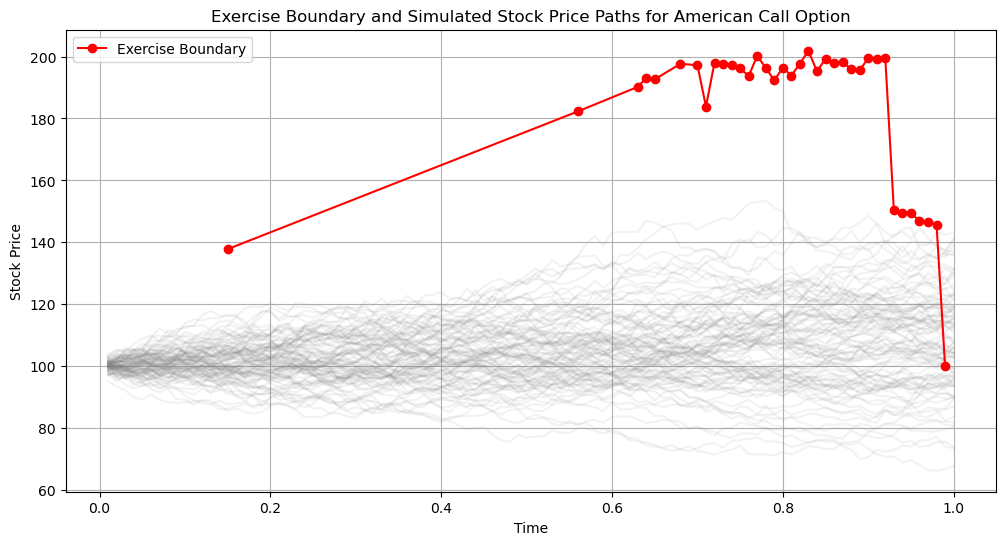

Option Value: 8.64701147292


In [14]:
#Call option exercsie boundary for the Hermite Polynomial
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)]  
    if k >= 1:
        A.append(X)  
    if k >= 2:
        A.append(X**2 - 1) 
    if k >= 3:
        A.append(X**3 - 3*X)  
    if k >= 4:
        A.append(X**4 - 6*X**2 + 3) 
    if k >= 5:
        A.append(X**5 - 10*X**3 + 15*X) 
    if k > 5:
        raise ValueError("Too many basis functions requested (max k=5)")
    A = np.column_stack(A)
    return A
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2, N)
    Z = np.concatenate([z, -z], axis=0)
    W = np.cumsum(np.sqrt(dt) * Z, axis=1)  
    S = S0 * np.exp((r - 0.5 * sigma**2) * t[1:] + sigma * W)  
    P = np.maximum(S[:, -1] - K, 0)
    
    exercise_boundaries = []
    for i in range(N - 1, 0, -1):
        itmP = np.where(S[:, i] - K > 0)[0]
        X = S[itmP, i] / K  
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = S[itmP, i] - K
        exP_local = np.where(C < E)[0] 
        P[itmP[exP_local]] = E[exP_local]
        P[itmP] = P[itmP] * np.exp(-r * dt)
        if len(exP_local) > 0:
            exercise_boundaries.append((t[i], np.min(S[itmP[exP_local], i])))
    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, exercise_boundaries, S, t

T = 1.0 
r = 0.05 
sigma = 0.15 
K = 100  
S0 = 100 
N = 100 
M = 1000000  
k = 5 

option_value, exercise_boundaries, S, t = LSM(T, r, sigma, K, S0, N, M, k)
times, boundaries = zip(*reversed(exercise_boundaries)) 
plt.figure(figsize=(12, 6))
num_paths_to_plot = 100
sample_paths = S[:num_paths_to_plot, :]
for i in range(num_paths_to_plot):
    plt.plot(t[1:], sample_paths[i, :], color='grey', alpha=0.1)
plt.plot(times, boundaries, marker='o', color='red', label='Exercise Boundary')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary and Simulated Stock Price Paths for American Call Option')
plt.legend()
plt.grid(True)
plt.show()

print(f"Option Value: {option_value}")


American Put Option Value: 4.2659


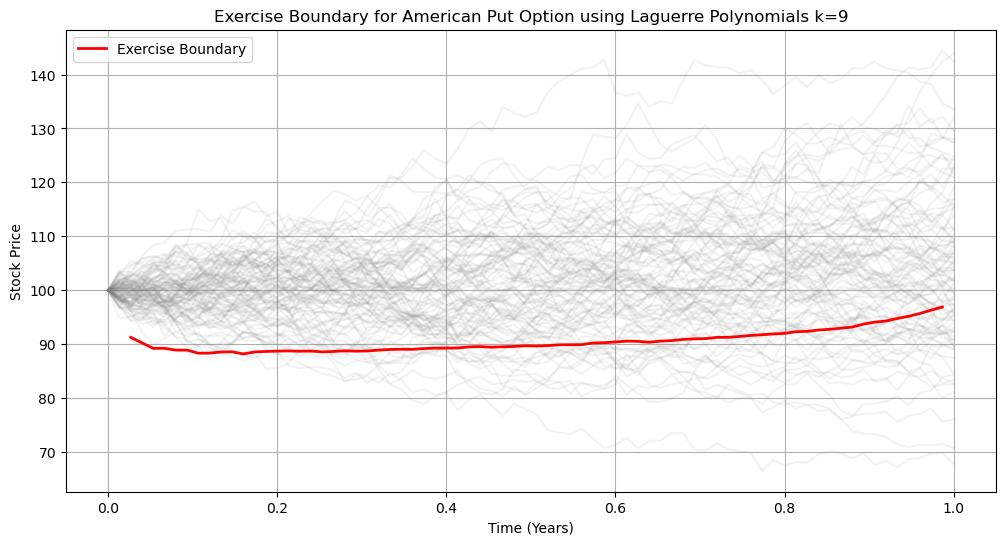

In [7]:
#Graphing for Laguerre poynomials of degree k=9

import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)]  # L0(x) = 1

    if k >= 1:
        A.append(1 - X)  # L1(x) = 1 - x
    if k >= 2:
        A.append(0.5 * (2 - 4*X + X**2))  # L2(x)
    if k >= 3:
        A.append((1/6) * (6 - 18*X + 9*X**2 - X**3))  # L3(x)
    if k >= 4:
        A.append((1/24) * (24 - 96*X + 72*X**2 - 16*X**3 + X**4))  # L4(x)
    if k >= 5:
        A.append((1/120) * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5))  # L5(x)
    if k >= 6:
        A.append((1/720) * (720 - 4320*X + 5400*X**2 - 2400*X**3 + 450*X**4 - 36*X**5 + X**6))  # L6(x)
    if k >= 7:
        A.append((1/5040) * (5040 - 35280*X + 52920*X**2 - 29400*X**3 + 7350*X**4 - 882*X**5 + 49*X**6 - X**7))  # L7(x)
    if k >= 8:
        A.append((1/40320) * (40320 - 322560*X + 564480*X**2 - 376320*X**3 + 117600*X**4 - 17640*X**5 + 1372*X**6 - 56*X**7 + X**8))  # L8(x)
    if k >= 9:
        A.append((1/362880) * (362880 - 3265920*X + 6531840*X**2 - 5227200*X**3 + 1995840*X**4 - 408240*X**5 + 45360*X**6 - 2520*X**7 + 63*X**8 - X**9))  # L9(x)

    if k > 9:
        raise ValueError("Maximum degree supported is 9. Please increase if needed.")
    A = np.column_stack(A)
    return A
    

def LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    np.random.seed(42)  
    z = np.random.randn(M, N)
    W = np.cumsum(np.sqrt(dt) * z, axis=1)
    W = np.hstack((np.zeros((M, 1)), W))
    S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    P = np.maximum(K - S[:, -1], 0)

    critical_prices = []
    for i in range(N - 1, 0, -1):
        itm = S[:, i] < K
        X = S[itm, i] / K  
        Y = P[itm] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - S[itm, i]
        exercise = E > C
        P[itm] = np.where(exercise, E, P[itm] * np.exp(-r * dt))
        X_grid = np.linspace(0.5, 1.0, 1000) 
        A_grid = basis_funct(X_grid, k)
        C_grid = A_grid @ beta
        E_grid = K - X_grid * K
        diff = E_grid - C_grid
        idx = np.where(diff >= 0)[0]
        if len(idx) == 0:
            critical_price = np.nan
        else:
            idx = idx[-1]
            if idx == len(X_grid) - 1:
                critical_price = X_grid[-1] * K
            else:

                x1, x2 = X_grid[idx], X_grid[idx + 1]
                y1, y2 = diff[idx], diff[idx + 1]
                critical_x = x1 + y1 * (x2 - x1) / (y1 - y2)
                critical_price = critical_x * K
        critical_prices.append(critical_price)

    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, critical_prices, S, t

T = 1.0   
r = 0.05   
sigma = 0.15 
K = 100   
S0 = 100   
N = 75    
M = 1000000  
k = 9     

put_option_value, critical_prices, S, t = LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k)
print(f"American Put Option Value: {put_option_value:.4f}")
critical_prices = critical_prices[::-1] 
t_plot = t[1:-1] 
critical_prices = np.array(critical_prices)
valid_indices = ~np.isnan(critical_prices)
t_valid = t_plot[valid_indices]
critical_prices_valid = critical_prices[valid_indices]

plt.figure(figsize=(12, 6))
num_paths_to_plot = 100
sample_paths = S[:num_paths_to_plot, :]
for i in range(num_paths_to_plot):
    plt.plot(t, sample_paths[i, :], color='grey', alpha=0.1)
plt.plot(t_valid, critical_prices_valid, label='Exercise Boundary', color='red', linewidth=2)

plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary for American Put Option using Laguerre Polynomials k=9')
plt.legend()
plt.grid(True)
plt.show()


American Put Option Value: 4.2527


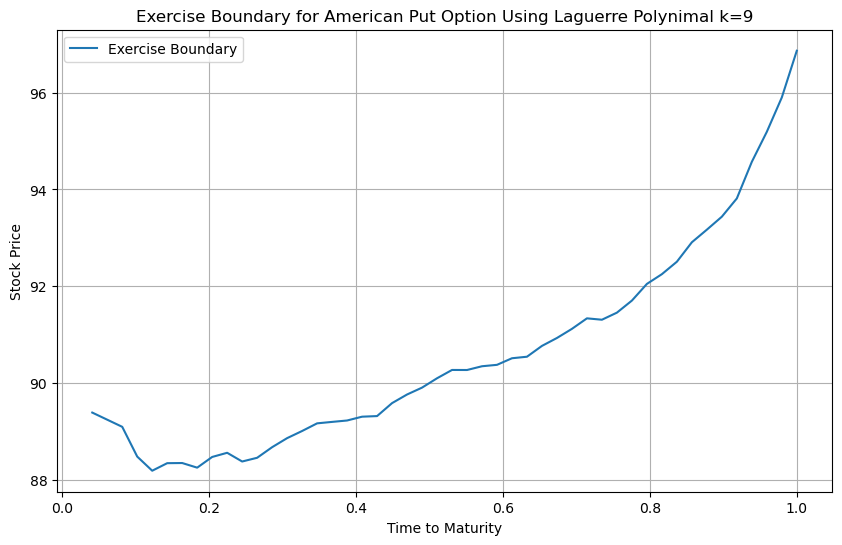

In [9]:
#Graphing for Laguerre k=9 with a smooth curve
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)] 
    if k >= 1:
        A.append(1 - X) 
    if k >= 2:
        A.append(0.5 * (2 - 4*X + X**2)) 
    if k >= 3:
        A.append((1/6) * (6 - 18*X + 9*X**2 - X**3))  
    if k >= 4:
        A.append((1/24) * (24 - 96*X + 72*X**2 - 16*X**3 + X**4))  
    if k >= 5:
        A.append((1/120) * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5)) 
    if k >= 6:
        A.append((1/720) * (720 - 4320*X + 5400*X**2 - 2400*X**3 + 450*X**4 - 36*X**5 + X**6)) 
    if k >= 7:
        A.append((1/5040) * (5040 - 35280*X + 52920*X**2 - 29400*X**3 + 7350*X**4 - 882*X**5 + 49*X**6 - X**7)) 
    if k >= 8:
        A.append((1/40320) * (40320 - 322560*X + 564480*X**2 - 376320*X**3 + 117600*X**4 - 17640*X**5 + 1372*X**6 - 56*X**7 + X**8)) 
    if k >= 9:
        A.append((1/362880) * (362880 - 3265920*X + 6531840*X**2 - 5227200*X**3 + 1995840*X**4 - 408240*X**5 + 45360*X**6 - 2520*X**7 + 63*X**8 - X**9)) 
    if k > 9:
        raise ValueError("Maximum degree supported is 9. Please increase if needed.")
    A = np.column_stack(A)
    return A

def LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    np.random.seed(42) 
    z = np.random.randn(M, N)
    W = np.cumsum(np.sqrt(dt) * z, axis=1)
    W = np.hstack((np.zeros((M, 1)), W))
    S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    P = np.maximum(K - S[:, -1], 0)

    critical_prices = []
    for i in range(N - 1, 0, -1):
        itm = S[:, i] < K
        X = S[itm, i]
        Y = P[itm] * np.exp(-r * dt)
        A = basis_funct(X / K, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - X
        exercise = E > C
        P[itm] = np.where(exercise, E, P[itm] * np.exp(-r * dt))
        X_grid = np.linspace(0.5 * K, K, 1000)  
        A_grid = basis_funct(X_grid / K, k)
        C_grid = A_grid @ beta
        E_grid = K - X_grid
        diff = E_grid - C_grid
        idx = np.where(diff >= 0)[0]
        if len(idx) == 0:
            critical_price = np.nan
        else:
            idx = idx[-1]
            if idx == len(X_grid) - 1:
                critical_price = X_grid[-1]
            else:
                x1, x2 = X_grid[idx], X_grid[idx + 1]
                y1, y2 = diff[idx], diff[idx + 1]
                critical_price = x1 + y1 * (x2 - x1) / (y1 - y2)
        critical_prices.append(critical_price)
    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, critical_prices

T = 1.0    
r = 0.05   
sigma = 0.15
K = 100   
S0 = 100    
N = 50  
M = 1000000 
k = 9      

put_option_value, critical_prices = LSM_with_boundary_put(T, r, sigma, K, S0, N, M, k)
print(f"American Put Option Value: {put_option_value:.4f}")
critical_prices = critical_prices[::-1]  
time_steps = np.linspace(0, T, N)[1:]  
critical_prices = np.array(critical_prices)
valid_indices = ~np.isnan(critical_prices)
time_steps_valid = time_steps[valid_indices]
critical_prices_valid = critical_prices[valid_indices]

plt.figure(figsize=(10, 6))
plt.plot(time_steps_valid, critical_prices_valid, label='Exercise Boundary')
plt.xlabel('Time to Maturity')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary for American Put Option Using Laguerre Polynimal k=9')
plt.legend()
plt.grid(True)
plt.show()


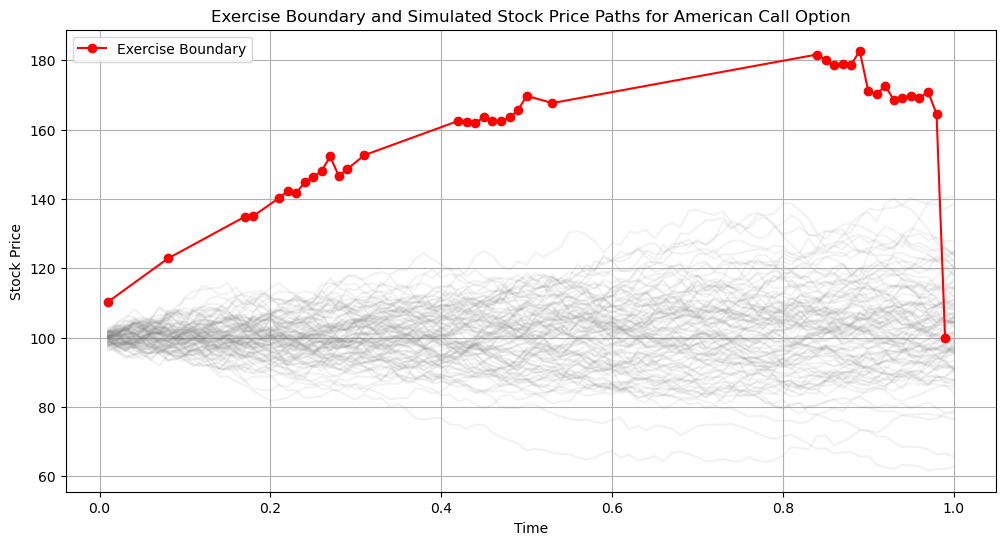

Option Value: 8.642176947110826


In [10]:
#Laguerre polynomial k=9 for call option
import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)] 
    if k >= 1:
        A.append(1 - X)
    if k >= 2:
        A.append(0.5 * (2 - 4*X + X**2)) 
    if k >= 3:
        A.append((1/6) * (6 - 18*X + 9*X**2 - X**3))
    if k >= 4:
        A.append((1/24) * (24 - 96*X + 72*X**2 - 16*X**3 + X**4))
    if k >= 5:
        A.append((1/120) * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5)) 
    if k >= 6:
        A.append((1/720) * (720 - 4320*X + 5400*X**2 - 2400*X**3 + 450*X**4 - 36*X**5 + X**6)) 
    if k >= 7:
        A.append((1/5040) * (5040 - 35280*X + 52920*X**2 - 29400*X**3 + 7350*X**4 - 882*X**5 + 49*X**6 - X**7))  
    if k >= 8:
        A.append((1/40320) * (40320 - 322560*X + 564480*X**2 - 376320*X**3 + 117600*X**4 - 17640*X**5 + 1372*X**6 - 56*X**7 + X**8)) 
    if k >= 9:
        A.append((1/362880) * (362880 - 3265920*X + 6531840*X**2 - 5227200*X**3 + 1995840*X**4 - 408240*X**5 + 45360*X**6 - 2520*X**7 + 63*X**8 - X**9)) 
    if k > 9:
        raise ValueError("Maximum degree supported is 9. Please increase if needed.")
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2, N)
    Z = np.concatenate([z, -z], axis=0)
    W = np.cumsum(np.sqrt(dt) * Z, axis=1) 
    S = S0 * np.exp((r - 0.5 * sigma**2) * t[1:] + sigma * W)  
    P = np.maximum(S[:, -1] - K, 0)
    
    exercise_boundaries = []
    for i in range(N - 1, 0, -1):
        itmP = np.where(S[:, i] - K > 0)[0]
        X = S[itmP, i] / K 
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = S[itmP, i] - K
        exP_local = np.where(C < E)[0]  
        P[itmP[exP_local]] = E[exP_local]
        P[itmP] = P[itmP] * np.exp(-r * dt)
        if len(exP_local) > 0:
            exercise_boundaries.append((t[i], np.min(S[itmP[exP_local], i])))

    option_value = np.mean(P) * np.exp(-r * dt)

    return option_value, exercise_boundaries, S, t

T = 1.0 
r = 0.05
sigma = 0.15 
K = 100  
S0 = 100  
N = 100 
M = 1000000 
k = 9  

option_value, exercise_boundaries, S, t = LSM(T, r, sigma, K, S0, N, M, k)
times, boundaries = zip(*reversed(exercise_boundaries)) 
plt.figure(figsize=(12, 6))
num_paths_to_plot = 100
sample_paths = S[:num_paths_to_plot, :]
for i in range(num_paths_to_plot):
    plt.plot(t[1:], sample_paths[i, :], color='grey', alpha=0.1)
plt.plot(times, boundaries, marker='o', color='red', label='Exercise Boundary')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Exercise Boundary and Simulated Stock Price Paths for American Call Option')
plt.legend()
plt.grid(True)
plt.show()

print(f"Option Value: {option_value}")

N=10, k=1, Mean Relative Error=0.018916
N=10, k=2, Mean Relative Error=0.011412
N=10, k=3, Mean Relative Error=0.010245
N=10, k=4, Mean Relative Error=0.010062
N=20, k=1, Mean Relative Error=0.015757
N=20, k=2, Mean Relative Error=0.006915
N=20, k=3, Mean Relative Error=0.004860
N=20, k=4, Mean Relative Error=0.004454
N=30, k=1, Mean Relative Error=0.015182
N=30, k=2, Mean Relative Error=0.005472
N=30, k=3, Mean Relative Error=0.003379
N=30, k=4, Mean Relative Error=0.002867
N=40, k=1, Mean Relative Error=0.015165
N=40, k=2, Mean Relative Error=0.005185
N=40, k=3, Mean Relative Error=0.002690
N=40, k=4, Mean Relative Error=0.002291
N=50, k=1, Mean Relative Error=0.015387
N=50, k=2, Mean Relative Error=0.004724
N=50, k=3, Mean Relative Error=0.002515
N=50, k=4, Mean Relative Error=0.002107
N=60, k=1, Mean Relative Error=0.015390
N=60, k=2, Mean Relative Error=0.004538
N=60, k=3, Mean Relative Error=0.002463
N=60, k=4, Mean Relative Error=0.002107
N=70, k=1, Mean Relative Error=0.015533


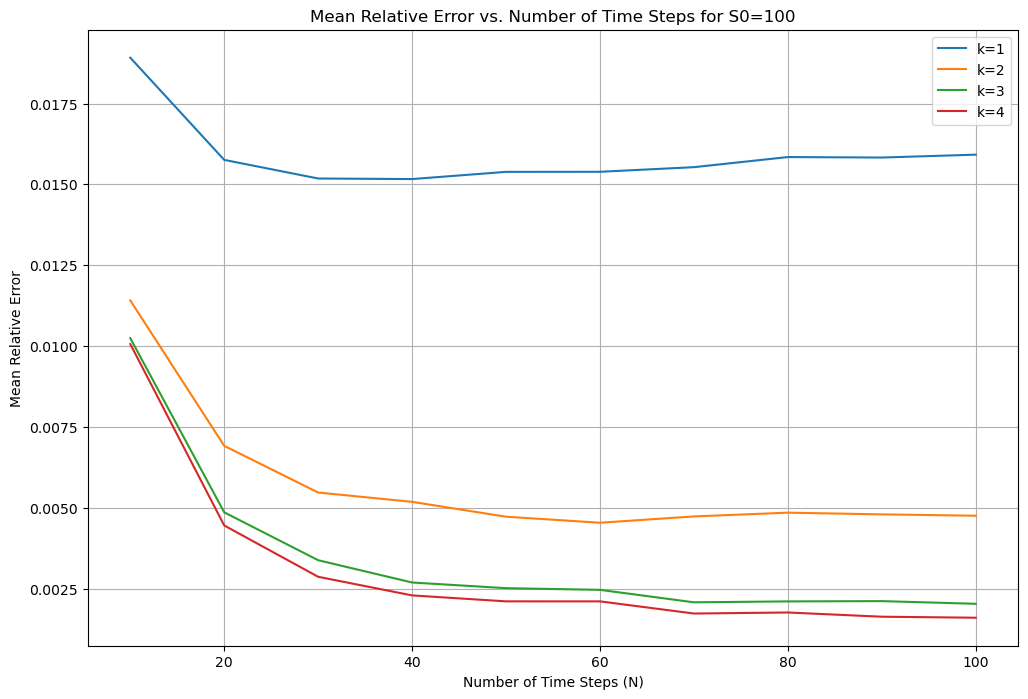

In [23]:
#Relative error for Laguerre Polynomial k=4

import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    if k == 1:
        A = np.column_stack([np.ones_like(X), 1 - X])
    elif k == 2:
        A = np.column_stack([
            np.ones_like(X), 
            1 - X, 
            0.5 * (2 - 4 * X + X**2)
        ])
    elif k == 3:
        A = np.column_stack([
            np.ones_like(X), 
            1 - X, 
            0.5 * (2 - 4 * X + X**2), 
            (1/6) * (6 - 18 * X + 9 * X**2 - X**3)
        ])
    elif k == 4:
        A = np.column_stack([
            np.ones_like(X), 
            1 - X, 
            0.5 * (2 - 4 * X + X**2), 
            (1/6) * (6 - 18 * X + 9 * X**2 - X**3),
            (1/24) * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4)
        ])
    else:
        raise ValueError("Too many basis functions requested")
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1)  
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)
    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue 
        X = S[itmP] / K 
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - S[itmP]
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value

T = 1         
r = 0.03     
sigma = 0.15  
K = 100       
S0 = 100      
M = 100000 
u_true = 4.820608184813253  
N_values = range(10, 101, 10) 
k_values = range(1, 5)     
num_samples = 20          

mean_relative_errors = {k: [] for k in k_values}
for N in N_values:
    for k in k_values:
        relative_errors = []
        for sample in range(num_samples):
            np.random.seed(sample)
            option_value = LSM(T, r, sigma, K, S0, N, M, k)
            e_r = abs((option_value - u_true) / u_true)
            relative_errors.append(e_r)
        mean_e_r = np.mean(relative_errors)
        mean_relative_errors[k].append(mean_e_r)
        print(f"N={N}, k={k}, Mean Relative Error={mean_e_r:.6f}")

plt.figure(figsize=(12, 8))
for k in k_values:
    plt.plot(N_values, mean_relative_errors[k], label=f'k={k}')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Mean Relative Error')
plt.title('Mean Relative Error vs. Number of Time Steps for S0=100')
plt.legend()
plt.grid(True)
plt.show()


N=10, k=1, Mean Relative Error=0.018916
N=10, k=2, Mean Relative Error=0.011412
N=10, k=3, Mean Relative Error=0.010245
N=10, k=4, Mean Relative Error=0.010062
N=20, k=1, Mean Relative Error=0.015757
N=20, k=2, Mean Relative Error=0.006915
N=20, k=3, Mean Relative Error=0.004860
N=20, k=4, Mean Relative Error=0.004454
N=30, k=1, Mean Relative Error=0.015182
N=30, k=2, Mean Relative Error=0.005472
N=30, k=3, Mean Relative Error=0.003379
N=30, k=4, Mean Relative Error=0.002867
N=40, k=1, Mean Relative Error=0.015165
N=40, k=2, Mean Relative Error=0.005185
N=40, k=3, Mean Relative Error=0.002690
N=40, k=4, Mean Relative Error=0.002291
N=50, k=1, Mean Relative Error=0.015387
N=50, k=2, Mean Relative Error=0.004724
N=50, k=3, Mean Relative Error=0.002515
N=50, k=4, Mean Relative Error=0.002107
N=60, k=1, Mean Relative Error=0.015390
N=60, k=2, Mean Relative Error=0.004538
N=60, k=3, Mean Relative Error=0.002463
N=60, k=4, Mean Relative Error=0.002107
N=70, k=1, Mean Relative Error=0.015533


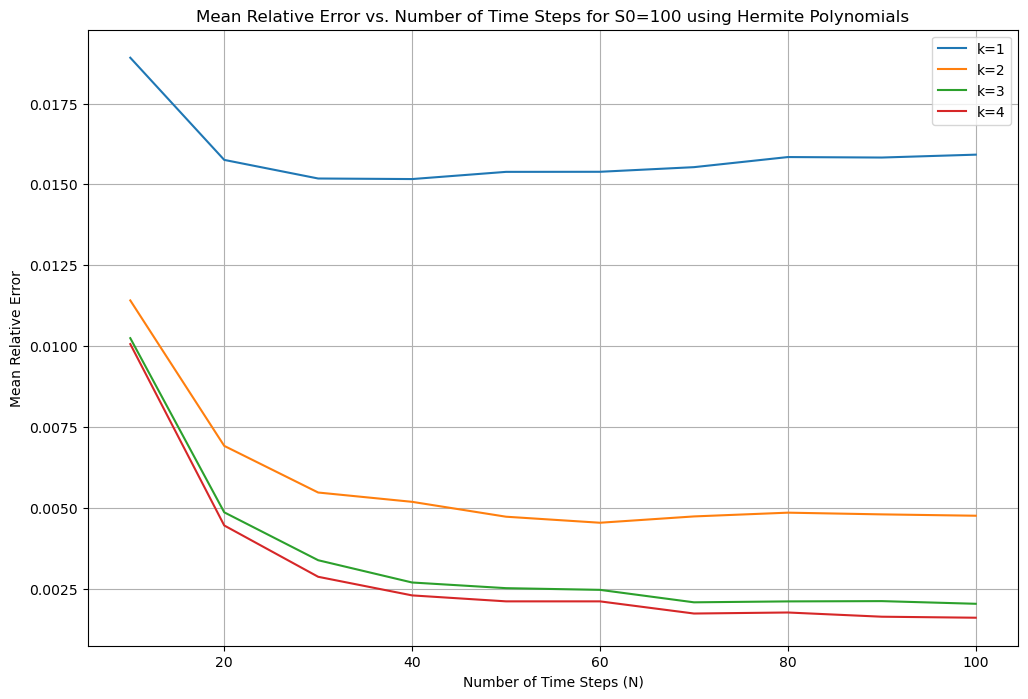

In [25]:
#Relative error for hermite polynomial

import numpy as np
import matplotlib.pyplot as plt

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)] 
    if k >= 1:
        A.append(X)
    if k >= 2:
        A.append(X**2 - 1) 
    if k >= 3:
        A.append(X**3 - 3*X) 
    if k >= 4:
        A.append(X**4 - 6*X**2 + 3)
    if k == 5
        A.append(X**5 - 10*X**3 + 15*X) 
    if k > 5:
        raise ValueError("Too many basis functions requested (max k=5)")
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)

    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue 
        X = S[itmP] / K  
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - S[itmP]
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value

T = 1      
r = 0.03    
sigma = 0.15 
K = 100     
S0 = 100   
M = 100000 
u_true = 4.820608184813253  
N_values = range(10, 101, 10) 
k_values = range(1, 5)     
num_samples = 20            
mean_relative_errors = {k: [] for k in k_values}

for N in N_values:
    for k in k_values:
        relative_errors = []
        for sample in range(num_samples):
            np.random.seed(sample)           
            option_value = LSM(T, r, sigma, K, S0, N, M, k)
            e_r = abs((option_value - u_true) / u_true)
            relative_errors.append(e_r)
        mean_e_r = np.mean(relative_errors)
        mean_relative_errors[k].append(mean_e_r)
        print(f"N={N}, k={k}, Mean Relative Error={mean_e_r:.6f}")
plt.figure(figsize=(12, 8))
for k in k_values:
    plt.plot(N_values, mean_relative_errors[k], label=f'k={k}')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Mean Relative Error')
plt.title('Mean Relative Error vs. Number of Time Steps for S0=100 using Hermite Polynomials')
plt.legend()
plt.grid(True)
plt.show()

N=10, k=1, Mean Relative Error=0.018916
N=10, k=5, Mean Relative Error=0.010060
N=10, k=7, Mean Relative Error=0.010023
N=10, k=9, Mean Relative Error=0.010034
N=20, k=1, Mean Relative Error=0.015757
N=20, k=5, Mean Relative Error=0.004414
N=20, k=7, Mean Relative Error=0.004443
N=20, k=9, Mean Relative Error=0.004399
N=30, k=1, Mean Relative Error=0.015182
N=30, k=5, Mean Relative Error=0.002983
N=30, k=7, Mean Relative Error=0.002821
N=30, k=9, Mean Relative Error=0.002826
N=40, k=1, Mean Relative Error=0.015165
N=40, k=5, Mean Relative Error=0.002304
N=40, k=7, Mean Relative Error=0.002169
N=40, k=9, Mean Relative Error=0.002134
N=50, k=1, Mean Relative Error=0.015387
N=50, k=5, Mean Relative Error=0.002011
N=50, k=7, Mean Relative Error=0.001893
N=50, k=9, Mean Relative Error=0.001883
N=60, k=1, Mean Relative Error=0.015390
N=60, k=5, Mean Relative Error=0.002057
N=60, k=7, Mean Relative Error=0.002001
N=60, k=9, Mean Relative Error=0.001960
N=70, k=1, Mean Relative Error=0.015533


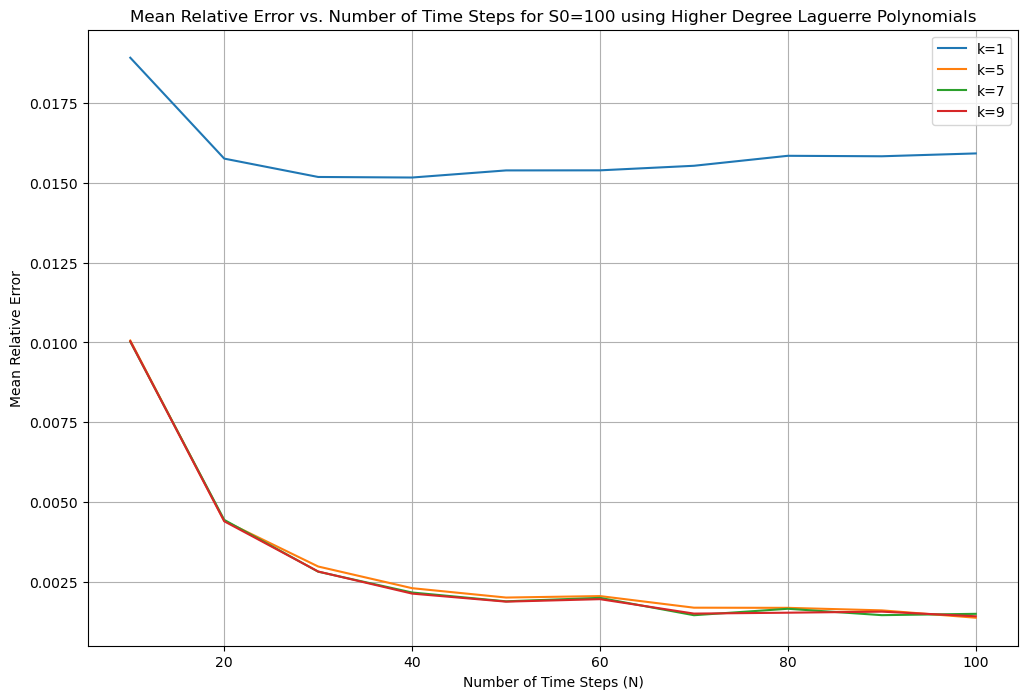

In [26]:
#Relative error for Laguerre polynomials of degree k=9

import numpy as np
import matplotlib.pyplot as plt
def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)] 
    if k >= 1:
        A.append(1 - X) 
    if k >= 2:
        A.append(0.5 * (2 - 4*X + X**2))  
    if k >= 3:
        A.append((1/6) * (6 - 18*X + 9*X**2 - X**3))
    if k >= 4:
        A.append((1/24) * (24 - 96*X + 72*X**2 - 16*X**3 + X**4)) 
    if k >= 5:
        A.append((1/120) * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5)) 
    if k >= 6:
        A.append((1/720) * (720 - 4320*X + 5400*X**2 - 2400*X**3 + 450*X**4 - 36*X**5 + X**6)) 
    if k >= 7:
        A.append((1/5040) * (5040 - 35280*X + 52920*X**2 - 29400*X**3 + 7350*X**4 - 882*X**5 + 49*X**6 - X**7)) 
    if k >= 8:
        A.append((1/40320) * (40320 - 322560*X + 564480*X**2 - 376320*X**3 + 117600*X**4 - 17640*X**5 + 1372*X**6 - 56*X**7 + X**8))  
    if k >= 9:
        A.append((1/362880) * (362880 - 3265920*X + 6531840*X**2 - 5227200*X**3 + 1995840*X**4 - 408240*X**5 + 45360*X**6 - 2520*X**7 + 63*X**8 - X**9))  
    if k > 9:
        raise ValueError("Maximum degree supported is 9. Please increase if needed.")
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)

    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue  
        X = S[itmP] / K 
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - S[itmP]
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value

T = 1       
r = 0.03   
sigma = 0.15 
K = 100     
S0 = 100
M = 100000 
u_true = 4.820608184813253 
N_values = range(10, 101, 10) 
k_values = 1, 5, 7, 9 
num_samples = 20          
mean_relative_errors = {k: [] for k in k_values}

for N in N_values:
    for k in k_values:
        relative_errors = []
        for sample in range(num_samples):
            np.random.seed(sample)
            option_value = LSM(T, r, sigma, K, S0, N, M, k)
            e_r = abs((option_value - u_true) / u_true)
            relative_errors.append(e_r)
        mean_e_r = np.mean(relative_errors)
        mean_relative_errors[k].append(mean_e_r)
        print(f"N={N}, k={k}, Mean Relative Error={mean_e_r:.6f}")
plt.figure(figsize=(12, 8))
for k in k_values:
    plt.plot(N_values, mean_relative_errors[k], label=f'k={k}')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Mean Relative Error')
plt.title('Mean Relative Error vs. Number of Time Steps for S0=100 using Higher Degree Laguerre Polynomials')
plt.legend()
plt.grid(True)
plt.show()

N=10, Mean Estimated Option Value=4.772161, CI=(4.766836, 4.777486)
N=20, Mean Estimated Option Value=4.798848, CI=(4.794256, 4.803441)
N=30, Mean Estimated Option Value=4.807373, CI=(4.802610, 4.812137)
N=40, Mean Estimated Option Value=4.810282, CI=(4.805801, 4.814763)
N=50, Mean Estimated Option Value=4.811844, CI=(4.806810, 4.816879)
N=60, Mean Estimated Option Value=4.814197, CI=(4.809198, 4.819195)
N=70, Mean Estimated Option Value=4.813263, CI=(4.808404, 4.818123)
N=80, Mean Estimated Option Value=4.815011, CI=(4.810562, 4.819459)
N=90, Mean Estimated Option Value=4.815999, CI=(4.811117, 4.820880)
N=100, Mean Estimated Option Value=4.815536, CI=(4.811322, 4.819750)


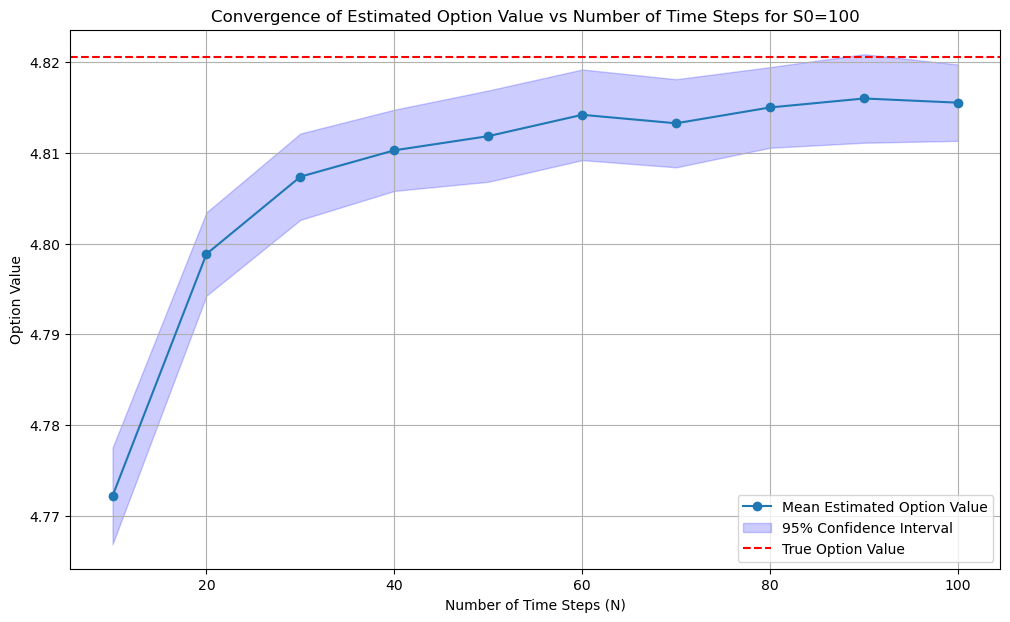

In [28]:
#Convergence of Laguerre Polynomial of degree 4

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def basis_funct(X, k):
    X = np.asarray(X)
    if k == 1:
        A = np.column_stack([np.ones_like(X), 1 - X])
    elif k == 2:
        A = np.column_stack([np.ones_like(X), 1 - X, 0.5 * (2 - 4 * X + X**2)])
    elif k == 3:
        A = np.column_stack([np.ones_like(X), 1 - X, 0.5 * (2 - 4 * X + X**2), 
                             (1/6) * (6 - 18 * X + 9 * X**2 - X**3)])
    elif k == 4:
        A = np.column_stack([np.ones_like(X), 1 - X, 0.5 * (2 - 4 * X + X**2), 
                             (1/6) * (6 - 18 * X + 9 * X**2 - X**3),
                             (1/24) * (24 - 96 * X + 72 * X**2 - 16 * X**3 + X**4)])
    else:
        raise ValueError("Too many basis functions requested")
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)
    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue 
        X = S[itmP]
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - X
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value

T = 1      
r = 0.03     
sigma = 0.15  
K = 100   
S0 = 100   
k = 4    
M = 100000  
num_samples = 20 
u_true = 4.820608184813253
N_values = range(10, 101, 10) 

mean_estimated_values = []
confidence_intervals = []
for N in N_values:
    estimated_values = []
    for sample in range(num_samples):
        np.random.seed(sample)
        option_value = LSM(T, r, sigma, K, S0, N, M, k)
        estimated_values.append(option_value)
    mean_option_value = np.mean(estimated_values)
    std_option_value = np.std(estimated_values, ddof=1) 
    mean_estimated_values.append(mean_option_value)
    confidence_level = 0.95
    degrees_freedom = num_samples - 1
    t_crit = np.abs(t.ppf((1 - confidence_level) / 2, degrees_freedom))
    margin_of_error = t_crit * (std_option_value / np.sqrt(num_samples))
    ci_lower = mean_option_value - margin_of_error
    ci_upper = mean_option_value + margin_of_error
    confidence_intervals.append((ci_lower, ci_upper))
    print(f"N={N}, Mean Estimated Option Value={mean_option_value:.6f}, CI=({ci_lower:.6f}, {ci_upper:.6f})")

ci_lower_bounds = [ci[0] for ci in confidence_intervals]
ci_upper_bounds = [ci[1] for ci in confidence_intervals]

plt.figure(figsize=(12, 7))
plt.plot(N_values, mean_estimated_values, marker='o', label='Mean Estimated Option Value')
plt.fill_between(N_values, ci_lower_bounds, ci_upper_bounds, color='b', alpha=0.2, label='95% Confidence Interval')
plt.axhline(y=u_true, color='r', linestyle='--', label='True Option Value')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Option Value')
plt.title('Convergence of Estimated Option Value vs Number of Time Steps for S0=100')
plt.legend()
plt.grid(True)
plt.show()


N=10, Mean Estimated Option Value=4.771890, CI=(4.766627, 4.777152)
N=20, Mean Estimated Option Value=4.798886, CI=(4.794377, 4.803395)
N=30, Mean Estimated Option Value=4.808472, CI=(4.803575, 4.813369)
N=40, Mean Estimated Option Value=4.811935, CI=(4.807453, 4.816416)
N=50, Mean Estimated Option Value=4.813717, CI=(4.808611, 4.818823)
N=60, Mean Estimated Option Value=4.814969, CI=(4.810279, 4.819658)
N=70, Mean Estimated Option Value=4.814919, CI=(4.810679, 4.819159)
N=80, Mean Estimated Option Value=4.816631, CI=(4.812551, 4.820712)
N=90, Mean Estimated Option Value=4.816575, CI=(4.812527, 4.820623)
N=100, Mean Estimated Option Value=4.816635, CI=(4.812707, 4.820564)


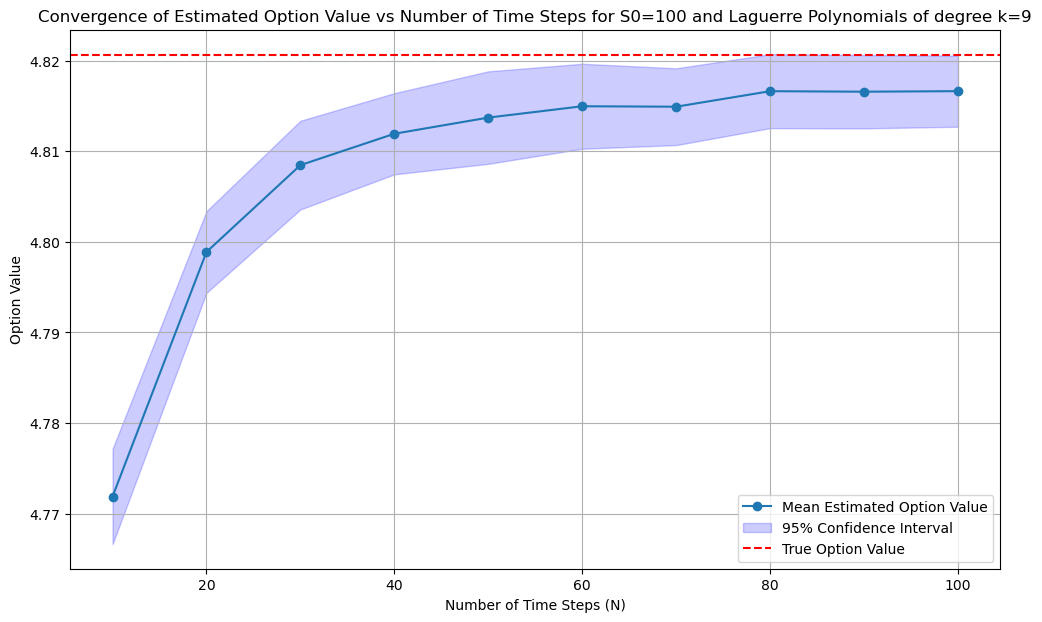

In [29]:
#Convergence of Laguerre Polynomial of degree 9

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)]  # L0(x) = 1

    if k >= 1:
        A.append(1 - X)  # L1(x) = 1 - x
    if k >= 2:
        A.append(0.5 * (2 - 4*X + X**2))  # L2(x)
    if k >= 3:
        A.append((1/6) * (6 - 18*X + 9*X**2 - X**3))  # L3(x)
    if k >= 4:
        A.append((1/24) * (24 - 96*X + 72*X**2 - 16*X**3 + X**4))  # L4(x)
    if k >= 5:
        A.append((1/120) * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5))  # L5(x)
    if k >= 6:
        A.append((1/720) * (720 - 4320*X + 5400*X**2 - 2400*X**3 + 450*X**4 - 36*X**5 + X**6))  # L6(x)
    if k >= 7:
        A.append((1/5040) * (5040 - 35280*X + 52920*X**2 - 29400*X**3 + 7350*X**4 - 882*X**5 + 49*X**6 - X**7))  # L7(x)
    if k >= 8:
        A.append((1/40320) * (40320 - 322560*X + 564480*X**2 - 376320*X**3 + 117600*X**4 - 17640*X**5 + 1372*X**6 - 56*X**7 + X**8))  # L8(x)
    if k >= 9:
        A.append((1/362880) * (362880 - 3265920*X + 6531840*X**2 - 5227200*X**3 + 1995840*X**4 - 408240*X**5 + 45360*X**6 - 2520*X**7 + 63*X**8 - X**9))  # L9(x)

    if k > 9:
        raise ValueError("Maximum degree supported is 9. Please increase if needed.")
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1)  
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)
    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue 
        X = S[itmP]
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - X
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value

T = 1    
r = 0.03    
sigma = 0.15  
K = 100    
S0 = 100    
k = 9       
M = 100000  
num_samples = 20 
u_true = 4.820608184813253
N_values = range(10, 101, 10)  

mean_estimated_values = []
confidence_intervals = []

for N in N_values:
    estimated_values = []
    for sample in range(num_samples):
        np.random.seed(sample)
        option_value = LSM(T, r, sigma, K, S0, N, M, k)
        estimated_values.append(option_value)
    mean_option_value = np.mean(estimated_values)
    std_option_value = np.std(estimated_values, ddof=1)  
    mean_estimated_values.append(mean_option_value)
    confidence_level = 0.95
    degrees_freedom = num_samples - 1
    t_crit = np.abs(t.ppf((1 - confidence_level) / 2, degrees_freedom))
    margin_of_error = t_crit * (std_option_value / np.sqrt(num_samples))
    ci_lower = mean_option_value - margin_of_error
    ci_upper = mean_option_value + margin_of_error
    confidence_intervals.append((ci_lower, ci_upper))

    print(f"N={N}, Mean Estimated Option Value={mean_option_value:.6f}, CI=({ci_lower:.6f}, {ci_upper:.6f})")
ci_lower_bounds = [ci[0] for ci in confidence_intervals]
ci_upper_bounds = [ci[1] for ci in confidence_intervals]

plt.figure(figsize=(12, 7))
plt.plot(N_values, mean_estimated_values, marker='o', label='Mean Estimated Option Value')
plt.fill_between(N_values, ci_lower_bounds, ci_upper_bounds, color='b', alpha=0.2, label='95% Confidence Interval')
plt.axhline(y=u_true, color='r', linestyle='--', label='True Option Value')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Option Value')
plt.title('Convergence of Estimated Option Value vs Number of Time Steps for S0=100 and Laguerre Polynomials of degree k=9')
plt.legend()
plt.grid(True)
plt.show()

N=10, Mean Estimated Option Value=4.771473, CI=(4.766362, 4.776585)
N=20, Mean Estimated Option Value=4.798042, CI=(4.793244, 4.802840)
N=30, Mean Estimated Option Value=4.805296, CI=(4.800364, 4.810228)
N=40, Mean Estimated Option Value=4.809254, CI=(4.804558, 4.813951)
N=50, Mean Estimated Option Value=4.810409, CI=(4.805475, 4.815342)
N=60, Mean Estimated Option Value=4.812661, CI=(4.807731, 4.817592)
N=70, Mean Estimated Option Value=4.811825, CI=(4.807314, 4.816337)
N=80, Mean Estimated Option Value=4.812766, CI=(4.808074, 4.817458)
N=90, Mean Estimated Option Value=4.813051, CI=(4.807533, 4.818570)
N=100, Mean Estimated Option Value=4.813151, CI=(4.808751, 4.817552)


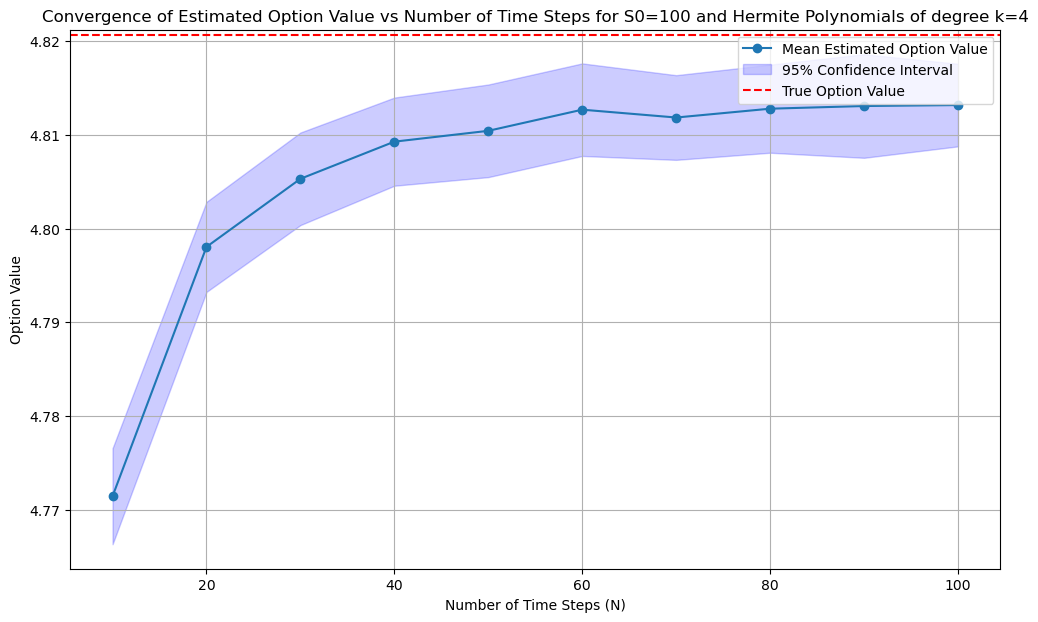

In [30]:
#Convergence of Hermite Polynomials of degree 4

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)] 
    if k >= 1:
        A.append(X) 
    if k >= 2:
        A.append(X**2 - 1)  
    if k >= 3:
        A.append(X**3 - 3*X)  
    if k >= 4:
        A.append(X**4 - 6*X**2 + 3)  
    if k >= 5:
        A.append(X**5 - 10*X**3 + 15*X) 
    if k > 5:
        raise ValueError("Too many basis functions requested (max k=5)")
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)
    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue  
        X = S[itmP]
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - X
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value

T = 1       
r = 0.03     
sigma = 0.15 
K = 100     
S0 = 100     
k = 4        
M = 100000   
num_samples = 20  
u_true = 4.820608184813253
N_values = range(10, 101, 10) 

mean_estimated_values = []
confidence_intervals = []

for N in N_values:
    estimated_values = []
    for sample in range(num_samples):
        np.random.seed(sample)
        option_value = LSM(T, r, sigma, K, S0, N, M, k)
        estimated_values.append(option_value)
    mean_option_value = np.mean(estimated_values)
    std_option_value = np.std(estimated_values, ddof=1) 
    mean_estimated_values.append(mean_option_value)
    confidence_level = 0.95
    degrees_freedom = num_samples - 1
    t_crit = np.abs(t.ppf((1 - confidence_level) / 2, degrees_freedom))
    margin_of_error = t_crit * (std_option_value / np.sqrt(num_samples))
    ci_lower = mean_option_value - margin_of_error
    ci_upper = mean_option_value + margin_of_error
    confidence_intervals.append((ci_lower, ci_upper))
    print(f"N={N}, Mean Estimated Option Value={mean_option_value:.6f}, CI=({ci_lower:.6f}, {ci_upper:.6f})")
ci_lower_bounds = [ci[0] for ci in confidence_intervals]
ci_upper_bounds = [ci[1] for ci in confidence_intervals]

plt.figure(figsize=(12, 7))
plt.plot(N_values, mean_estimated_values, marker='o', label='Mean Estimated Option Value')
plt.fill_between(N_values, ci_lower_bounds, ci_upper_bounds, color='b', alpha=0.2, label='95% Confidence Interval')
plt.axhline(y=u_true, color='r', linestyle='--', label='True Option Value')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Option Value')
plt.title('Convergence of Estimated Option Value vs Number of Time Steps for S0=100 and Hermite Polynomials of degree k=4')
plt.legend()
plt.grid(True)
plt.show()

Running simulations for k = 1
N = 10, Execution Time = 0.1000 seconds
N = 20, Execution Time = 0.1571 seconds
N = 30, Execution Time = 0.1799 seconds
N = 40, Execution Time = 0.2742 seconds
N = 50, Execution Time = 0.3477 seconds
N = 60, Execution Time = 0.4209 seconds
N = 70, Execution Time = 0.3926 seconds
N = 80, Execution Time = 0.5118 seconds
N = 90, Execution Time = 0.5385 seconds
N = 100, Execution Time = 0.6593 seconds

Running simulations for k = 2
N = 10, Execution Time = 0.0835 seconds
N = 20, Execution Time = 0.1432 seconds
N = 30, Execution Time = 0.1882 seconds
N = 40, Execution Time = 0.2471 seconds
N = 50, Execution Time = 0.4057 seconds
N = 60, Execution Time = 0.5005 seconds
N = 70, Execution Time = 0.4543 seconds
N = 80, Execution Time = 0.6331 seconds
N = 90, Execution Time = 0.6955 seconds
N = 100, Execution Time = 0.6772 seconds

Running simulations for k = 3
N = 10, Execution Time = 0.1032 seconds
N = 20, Execution Time = 0.1571 seconds
N = 30, Execution Time = 0

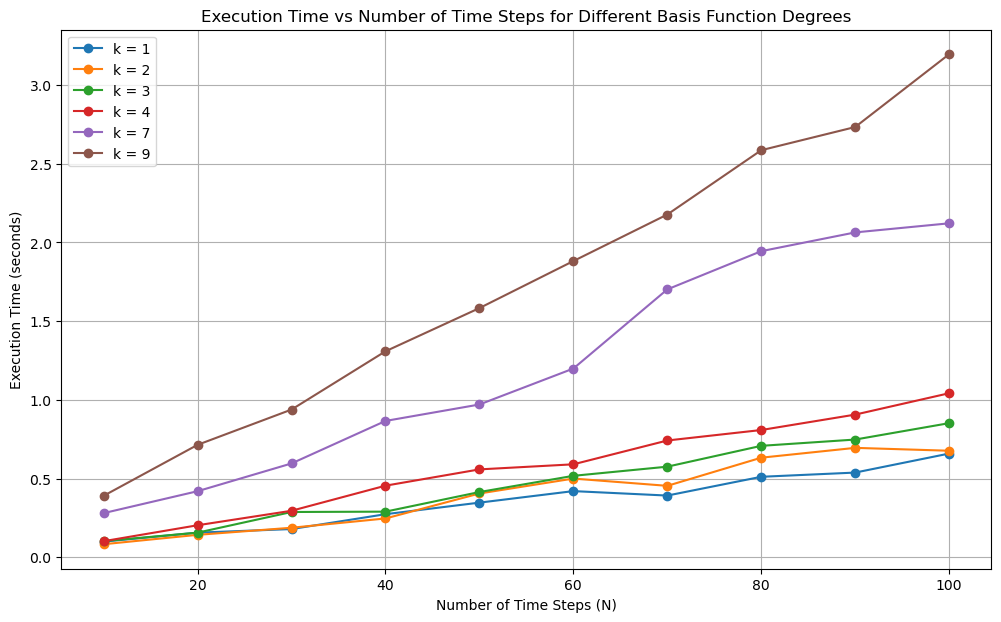

In [32]:
#Execution time for Laguere Polynomials
import numpy as np
import matplotlib.pyplot as plt
import time

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)] 
    if k >= 1:
        A.append(1 - X)  
    if k >= 2:
        A.append(0.5 * (2 - 4*X + X**2)) 
    if k >= 3:
        A.append((1/6) * (6 - 18*X + 9*X**2 - X**3))  
    if k >= 4:
        A.append((1/24) * (24 - 96*X + 72*X**2 - 16*X**3 + X**4))  
    if k >= 5:
        A.append((1/120) * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5))  
    if k >= 6:
        A.append((1/720) * (720 - 4320*X + 5400*X**2 - 2400*X**3 + 450*X**4 - 36*X**5 + X**6)) 
    if k >= 7:
        A.append((1/5040) * (5040 - 35280*X + 52920*X**2 - 29400*X**3 + 7350*X**4 - 882*X**5 + 49*X**6 - X**7))  
    if k >= 8:
        A.append((1/40320) * (40320 - 322560*X + 564480*X**2 - 376320*X**3 + 117600*X**4 - 17640*X**5 + 1372*X**6 - 56*X**7 + X**8))  
    if k >= 9:
        A.append((1/362880) * (362880 - 3265920*X + 6531840*X**2 - 5227200*X**3 + 1995840*X**4 - 408240*X**5 + 45360*X**6 - 2520*X**7 + 63*X**8 - X**9)) 
    if k > 9:
        raise ValueError("Maximum degree supported is 9. Please increase if needed.")
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)
    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue
        X = S[itmP] / K 
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - S[itmP]
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value
import time

T = 1       
r = 0.03     
sigma = 0.15 
K = 100      
S0 = 100     
M = 100000   
N_values = range(10, 101, 10) 
k_values = [1, 2, 3, 4, 7, 9]         
execution_times = {k: [] for k in k_values}

for k in k_values:
    print(f"Running simulations for k = {k}")
    for N in N_values:
        start_time = time.time()
        np.random.seed(0)
        option_value = LSM(T, r, sigma, K, S0, N, M, k)
        end_time = time.time()
        elapsed_time = end_time - start_time
        execution_times[k].append(elapsed_time)
        print(f"N = {N}, Execution Time = {elapsed_time:.4f} seconds")
    print()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
for k in k_values:
    plt.plot(N_values, execution_times[k], marker='o', label=f'k = {k}')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Number of Time Steps for Different Basis Function Degrees')
plt.legend()
plt.grid(True)
plt.show()


Running simulations for k = 1
N = 10, Execution Time = 0.0556 seconds
N = 20, Execution Time = 0.1009 seconds
N = 30, Execution Time = 0.1858 seconds
N = 40, Execution Time = 0.2009 seconds
N = 50, Execution Time = 0.2794 seconds
N = 60, Execution Time = 0.3529 seconds
N = 70, Execution Time = 0.4373 seconds
N = 80, Execution Time = 0.4331 seconds
N = 90, Execution Time = 0.4308 seconds
N = 100, Execution Time = 0.5012 seconds

Running simulations for k = 2
N = 10, Execution Time = 0.0675 seconds
N = 20, Execution Time = 0.1095 seconds
N = 30, Execution Time = 0.1743 seconds
N = 40, Execution Time = 0.2255 seconds
N = 50, Execution Time = 0.2725 seconds
N = 60, Execution Time = 0.3452 seconds
N = 70, Execution Time = 0.3747 seconds
N = 80, Execution Time = 0.4544 seconds
N = 90, Execution Time = 0.4777 seconds
N = 100, Execution Time = 0.5812 seconds

Running simulations for k = 3
N = 10, Execution Time = 0.0644 seconds
N = 20, Execution Time = 0.1460 seconds
N = 30, Execution Time = 0

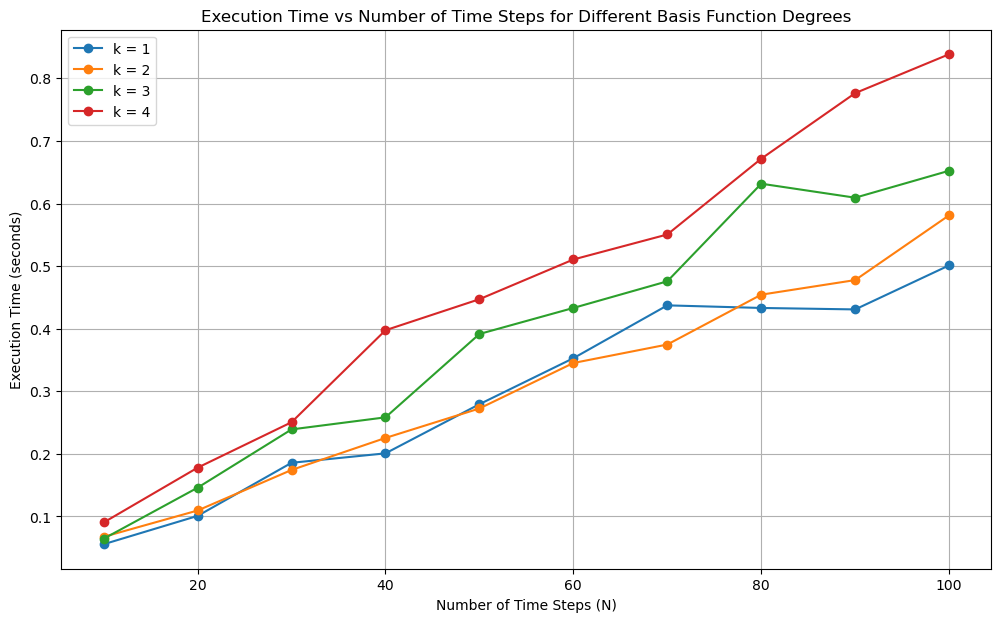

In [33]:
#Execution time for Hermite Polynomials
import numpy as np
import matplotlib.pyplot as plt
import time

def basis_funct(X, k):
    X = np.asarray(X)
    A = [np.ones_like(X)]  # H0(x) = 1
    if k >= 1:
        A.append(X) 
    if k >= 2:
        A.append(X**2 - 1) 
    if k >= 3:
        A.append(X**3 - 3*X) 
    if k >= 4:
        A.append(X**4 - 6*X**2 + 3) 
    if k >= 5:
        A.append(X**5 - 10*X**3 + 15*X) 
    if k > 5:
        raise ValueError("Too many basis functions requested (max k=5)")
    A = np.column_stack(A)
    return A

def LSM(T, r, sigma, K, S0, N, M, k):
    dt = T / N
    t = np.linspace(0, T, N + 1) 
    z = np.random.randn(M // 2)
    w = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.concatenate([z, -z])
    S = S0 * np.exp(w)
    P = np.maximum(K - S, 0)
    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        w = t[i] * w / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate([z, -z])
        S = S0 * np.exp(w)
        itmP = np.where(K - S > 0)[0]
        if len(itmP) == 0:
            P = P * np.exp(-r * dt)
            continue
        X = S[itmP] / K 
        Y = P[itmP] * np.exp(-r * dt)
        A = basis_funct(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]
        C = A @ beta
        E = K - S[itmP]
        exercise = C < E
        P[itmP[exercise]] = E[exercise]
        P = P * np.exp(-r * dt)
    option_value = np.mean(P) * np.exp(-r * dt)
    return option_value
import time

T = 1     
r = 0.03  
sigma = 0.15 
K = 100     
S0 = 100    
M = 100000   
N_values = range(10, 101, 10) 
k_values = [1, 2, 3, 4]      
execution_times = {k: [] for k in k_values}

for k in k_values:
    print(f"Running simulations for k = {k}")
    for N in N_values:
        start_time = time.time()
        # Reset random seed for consistency
        np.random.seed(0)
        option_value = LSM(T, r, sigma, K, S0, N, M, k)
        end_time = time.time()
        elapsed_time = end_time - start_time
        execution_times[k].append(elapsed_time)
        print(f"N = {N}, Execution Time = {elapsed_time:.4f} seconds")
    print()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
for k in k_values:
    plt.plot(N_values, execution_times[k], marker='o', label=f'k = {k}')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Number of Time Steps for Different Basis Function Degrees')
plt.legend()
plt.grid(True)
plt.show()
